In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Introduction
This notebook is a project of Nanodegree at Udacity "Machine Learning Fundamentals" Sponsored by AWS and Intel

## Loading needed Libraries

In [2]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
device=torch.device('cuda')
device 

device(type='cuda')

## Loading the data


 # Description
The MNIST database (Modified National Institute of Standards and Technology database) is a large collection of handwritten digits. It has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger NIST Special Database 3 (digits written by employees of the United States Census Bureau) and Special Database 1 (digits written by high school students) which contain monochrome images of handwritten digits. The digits have been size-normalized and centered in a fixed-size image. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.


In [4]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
train=datasets.MNIST(root="data",train=True,download=True,transform=transform)
test=datasets.MNIST(root="data",train=False,download=True,transform=transform)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=200)

100%|██████████| 9912422/9912422 [00:00<00:00, 97217422.48it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 45780685.50it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24811529.85it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6310211.58it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Visualization of the data

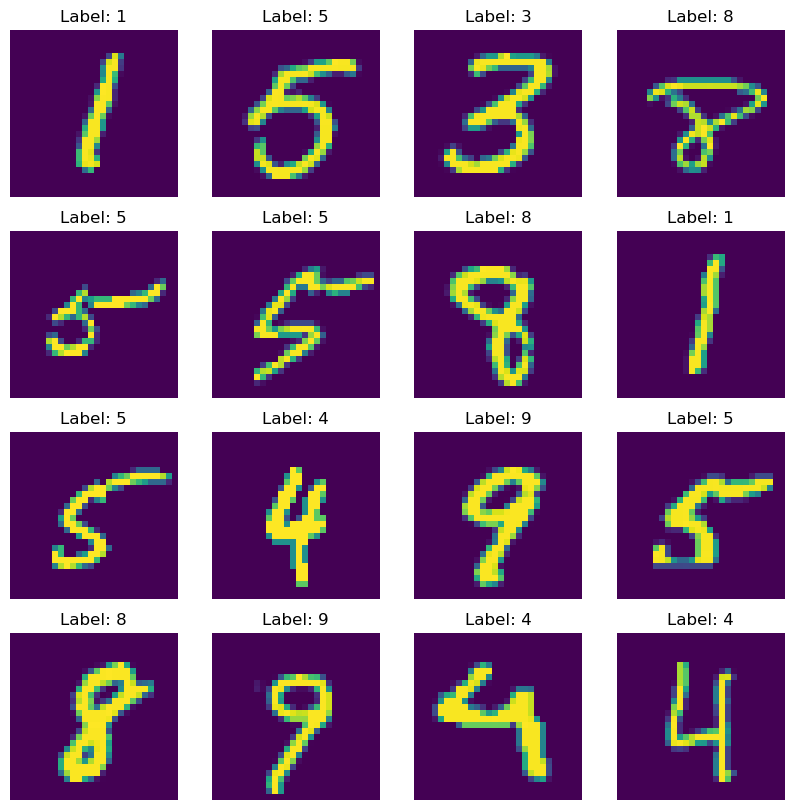

In [5]:
# Get a batch of data from the train_loader
dataiter = next(iter(train_loader))
images, labels = dataiter

# Plot multiple images from the batch
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    # Select a single image from the batch
    image = images[i]

    # Reshape the image to (height, width, num_channels)
    image = np.transpose(image, (1, 2, 0))

    # Display the image and label
    ax.imshow(image)
    ax.set_title(f"Label: {labels[i]}")
    ax.axis("off")

plt.show()

In [6]:
for X, y in train_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## Building the architecture of the model

In [7]:
class Net(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super().__init__()
        self.activation = F.relu
        self.dropout_prob = dropout_prob

        self.fc1 = nn.Linear(28*28, 512)
        self.dropout1 = nn.Dropout(p=dropout_prob)

        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(p=dropout_prob)

        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.dropout1(x)

        x = self.activation(self.fc2(x))
        x = self.dropout2(x)

        x = F.softmax(self.fc3(x))
        return x
net=Net()    
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

## Training phase

In [8]:
def train_model(net, train_loader, test_loader, num_epoch=50, lr=0.001, momentum=0.5):
    optimizer = optim.SGD(net.parameters(), lr=lr,momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    train_loss_history = []
    test_loss_history = []

    for epoch in range(num_epoch):
        net.train()
        train_loss = 0
        train_correct = 0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            output = net(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(output.data, 1)
            train_correct += (preds == labels).sum().item()
            train_loss += loss.item()

        train_loss_history.append(train_loss / len(train_loader))
        train_acc = train_correct / len(train_loader.dataset)

        net.eval()
        test_loss = 0.0
        test_correct = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs.data, 1)
                test_correct += (preds == labels).sum().item()
                test_loss += loss.item()

        test_loss_history.append(test_loss / len(test_loader))
        test_acc = test_correct / len(test_loader.dataset)

        print(f'Epoch {epoch + 1} training accuracy: {train_acc:.2f}% training loss: {train_loss / len(train_loader):.5f}')
        print(f'Epoch {epoch + 1} test accuracy: {test_acc:.2f}% test loss: {test_loss / len(test_loader):.5f}')

    plt.plot(train_loss_history, label="Training Loss")
    plt.plot(test_loss_history, label="test Loss")
    plt.legend()
    plt.show()

/tmp/ipykernel_24/2322356002.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


Epoch 1 training accuracy: 0.10% training loss: 2.30229
Epoch 1 test accuracy: 0.10% test loss: 2.30014
Epoch 2 training accuracy: 0.12% training loss: 2.29841
Epoch 2 test accuracy: 0.20% test loss: 2.29495
Epoch 3 training accuracy: 0.16% training loss: 2.29280
Epoch 3 test accuracy: 0.20% test loss: 2.28635
Epoch 4 training accuracy: 0.18% training loss: 2.28230
Epoch 4 test accuracy: 0.16% test loss: 2.26889
Epoch 5 training accuracy: 0.18% training loss: 2.26221
Epoch 5 test accuracy: 0.19% test loss: 2.23917
Epoch 6 training accuracy: 0.22% training loss: 2.23366
Epoch 6 test accuracy: 0.27% test loss: 2.20179
Epoch 7 training accuracy: 0.28% training loss: 2.19858
Epoch 7 test accuracy: 0.34% test loss: 2.15815
Epoch 8 training accuracy: 0.33% training loss: 2.15723
Epoch 8 test accuracy: 0.38% test loss: 2.10836
Epoch 9 training accuracy: 0.37% training loss: 2.11304
Epoch 9 test accuracy: 0.40% test loss: 2.06210
Epoch 10 training accuracy: 0.41% training loss: 2.07481
Epoch 1

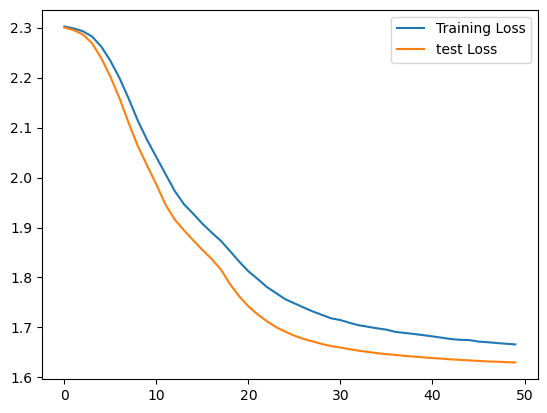

In [9]:
train_model(net,train_loader,test_loader)

## Modifing hyperparameter


/tmp/ipykernel_24/2322356002.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


Epoch 1 training accuracy: 0.81% training loss: 1.66532
Epoch 1 test accuracy: 0.84% test loss: 1.62891
Epoch 2 training accuracy: 0.81% training loss: 1.66449
Epoch 2 test accuracy: 0.84% test loss: 1.62854
Epoch 3 training accuracy: 0.81% training loss: 1.66315
Epoch 3 test accuracy: 0.84% test loss: 1.62791
Epoch 4 training accuracy: 0.81% training loss: 1.66325
Epoch 4 test accuracy: 0.84% test loss: 1.62770
Epoch 5 training accuracy: 0.81% training loss: 1.66117
Epoch 5 test accuracy: 0.84% test loss: 1.62707


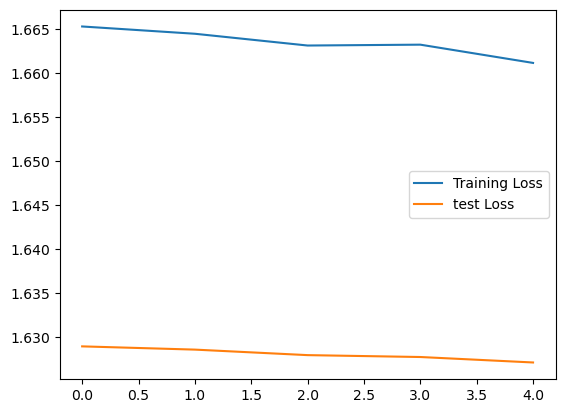

In [10]:
train_model(net, train_loader, test_loader, num_epoch=5, lr=0.001, momentum=0.3)

## Testing & Evaluation

In [11]:


def predict_and_display_image(model, device, image, true_label):
    # Move the image to the device
    image = image.to(device)

    # Make a prediction using the model
    with torch.no_grad():
        output = model(image.unsqueeze(0))

    # Move the output tensor to the CPU device and convert it to numpy
    output = output.cpu().numpy()

    # Get the predicted class for the image
    predicted_class = np.argmax(output)

    # Display the image using imshow
    plt.imshow(image.cpu(), cmap='gray')

    # Print the true label and predicted label for the image
    print("True Label: ", true_label)
    print("Predicted Label: ", predicted_class)


/tmp/ipykernel_24/2322356002.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


True Label:  tensor(7)
Predicted Label:  7


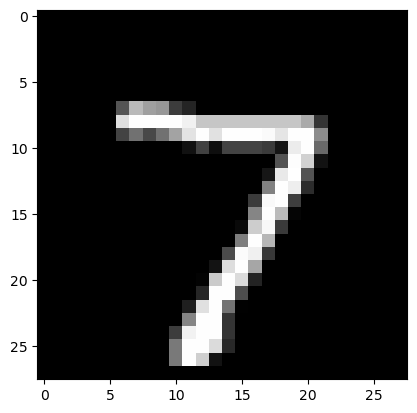

In [12]:

# Get a batch of data from the test loader
dataiter = next(iter(test_loader))
images, labels = dataiter

# Select a single image from the batch
img = images[0].squeeze()

# Use the predict_and_display_image function to make a prediction and display the image
predict_and_display_image(net, device, img, labels[0])

/tmp/ipykernel_24/2322356002.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


True Label:  tensor(1)
Predicted Label:  1


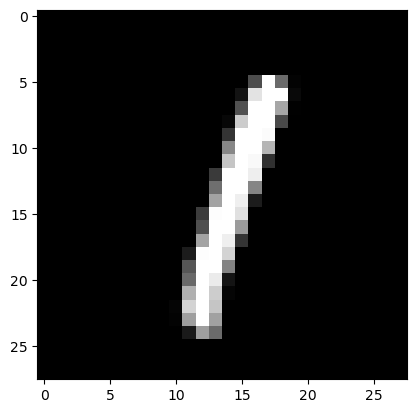

In [13]:

# Get a batch of data from the test loader
dataiter = next(iter(test_loader))
images, labels = dataiter

# Select a single image from the batch
img = images[5].squeeze()

# Use the predict_and_display_image function to make a prediction and display the image
predict_and_display_image(net, device, img, labels[5])

/tmp/ipykernel_24/2322356002.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


True Label:  tensor(7)
Predicted Label:  7


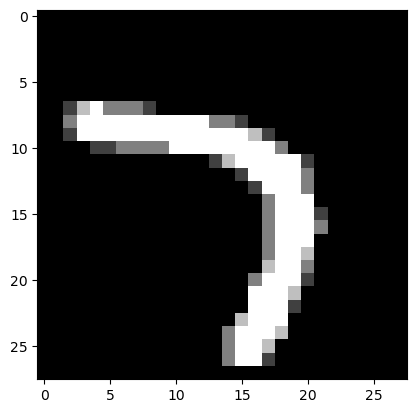

In [14]:

# Get a batch of data from the test loader
dataiter = next(iter(test_loader))
images, labels = dataiter

# Select a single image from the batch
img = images[60].squeeze()

# Use the predict_and_display_image function to make a prediction and display the image
predict_and_display_image(net, device, img, labels[60])

/tmp/ipykernel_24/2322356002.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


True Label:  tensor(6)
Predicted Label:  6


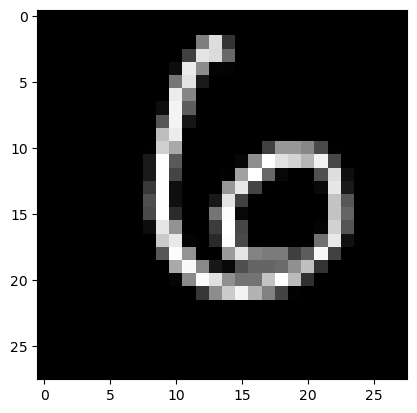

In [15]:

# Get a batch of data from the test loader
dataiter = next(iter(test_loader))
images, labels = dataiter

# Select a single image from the batch
img = images[100].squeeze()

# Use the predict_and_display_image function to make a prediction and display the image
predict_and_display_image(net, device, img, labels[100])

## Saving and loading the Model


In [16]:
torch.save(net.state_dict(), 'mnist_model.pth')

In [17]:
net.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.0061,  0.0273, -0.0102,  ...,  0.0291,  0.0068, -0.0132],
                      [ 0.0331,  0.0158,  0.0022,  ..., -0.0072, -0.0299, -0.0070],
                      [-0.0344,  0.0297,  0.0197,  ..., -0.0004, -0.0179, -0.0341],
                      ...,
                      [ 0.0109, -0.0276, -0.0064,  ...,  0.0063, -0.0055,  0.0157],
                      [ 0.0237, -0.0109,  0.0105,  ..., -0.0104,  0.0148, -0.0009],
                      [ 0.0199, -0.0243,  0.0279,  ...,  0.0016, -0.0073,  0.0113]],
                     device='cuda:0')),
             ('fc1.bias',
              tensor([ 3.0345e-02, -1.5614e-02,  1.9508e-02,  3.4394e-02,  3.0581e-02,
                       5.2691e-03, -7.3270e-03, -5.5055e-03, -2.0133e-02, -2.5871e-02,
                      -1.1723e-03,  9.4319e-03,  6.7271e-03, -1.2048e-02,  4.3773e-03,
                       1.8646e-03,  3.1699e-02, -3.0987e-02, -3.9036e-04,  7.9613e-03,
                      -1.9